<a href="https://colab.research.google.com/github/chuckmaini/colab/blob/main/Chapter2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
%%javascript
function KeepClicking() {
    console.log('Clicking');
    document.querySelector('colab-connect-button').click()
}
setInterval (KeepClicking, 60000)

<IPython.core.display.Javascript object>

In [3]:
!pip install -Uqq fastbook --upgrade
!pip install utils
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 17.9MB/s 
     |████████████████████████████████| 51kB 8.4MB/s 
     |████████████████████████████████| 194kB 49.4MB/s 
     |████████████████████████████████| 1.2MB 52.1MB/s 
     |████████████████████████████████| 61kB 10.0MB/s 


In [4]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [5]:
def search_images_ddg(key,max_n=200):
     """Search for 'key' with DuckDuckGo and return a unique urls of 'max_n' images """
     url        = 'https://duckduckgo.com/'
     params     = {'q':key}
     res        = requests.post(url,data=params)
     searchObj  = re.search(r'vqd=([\d-]+)\&',res.text)
     if not searchObj: print('Token Parsing Failed !'); return
     requestUrl = url + 'i.js'
     headers    = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:71.0) Gecko/20100101 Firefox/71.0'}
     params     = (('l','us-en'),('o','json'),('q',key),('vqd',searchObj.group(1)),('f',',,,'),('p','1'),('v7exp','a'))
     urls       = []
     while True:
         try:
             res  = requests.get(requestUrl,headers=headers,params=params)
             data = json.loads(res.text)
             for obj in data['results']:
                 urls.append(obj['image'])
                 max_n = max_n - 1
                 if max_n < 1: return L(set(urls))     # dedupe                                                                                       
             if 'next' not in data: return L(set(urls))
             requestUrl = url + data['next']
         except:
             pass

In [7]:
urls = search_images_ddg('grizzly bear')
len(urls),urls[0]

(186,
 'http://fscdn.wcs.org/2015/09/18/2m1b3bm5pu_Julie_Larsen_Maher_1295_Grizzly_Bears_and_Brown_Bears_with_Pumpkin_Enrichment_BB_BZ_09_15_11_hr.jpg')

In [9]:
len(urls)

186

In [11]:
dest = 'grizzly.jpg'
download_url(urls[0], dest)

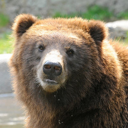

In [12]:
im = Image.open(dest)
im.to_thumb(128,128)

In [13]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [15]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'{o} bear')
        download_images(dest, urls=urls)

In [16]:
fns = get_image_files(path)
fns

(#500) [Path('bears/grizzly/00000030.jpg'),Path('bears/grizzly/00000180.jpg'),Path('bears/grizzly/00000062.jpg'),Path('bears/grizzly/00000004.jpg'),Path('bears/grizzly/00000173.jpg'),Path('bears/grizzly/00000112.jpg'),Path('bears/grizzly/00000082.jpg'),Path('bears/grizzly/00000001.jpg'),Path('bears/grizzly/00000158.jpg'),Path('bears/grizzly/00000057.jpg')...]

In [17]:
failed = verify_images(fns)
failed

(#6) [Path('bears/grizzly/00000076.jpg'),Path('bears/grizzly/00000183.jpg'),Path('bears/teddy/00000076.jpg'),Path('bears/teddy/00000183.jpg'),Path('bears/black/00000076.jpg'),Path('bears/black/00000183.jpg')]

In [18]:
failed.map(Path.unlink)

(#6) [None,None,None,None,None,None]

In [19]:
failed

(#6) [Path('bears/grizzly/00000076.jpg'),Path('bears/grizzly/00000183.jpg'),Path('bears/teddy/00000076.jpg'),Path('bears/teddy/00000183.jpg'),Path('bears/black/00000076.jpg'),Path('bears/black/00000183.jpg')]

In [23]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [24]:
dls = bears.dataloaders(path)

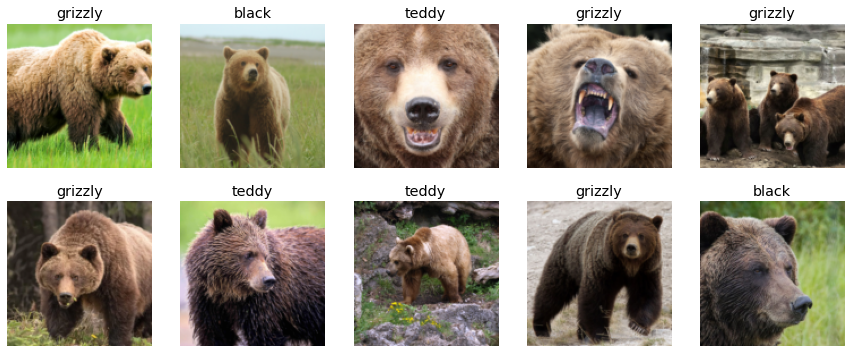

In [25]:
dls.valid.show_batch(max_n=10, nrows=2)

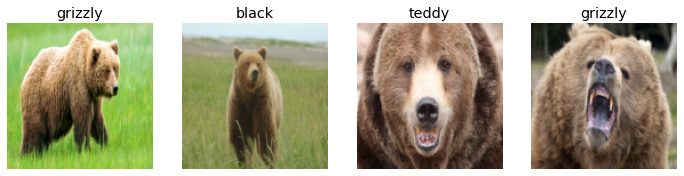

In [26]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

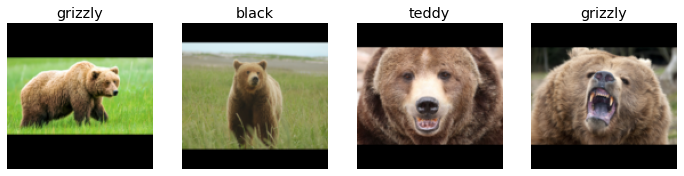

In [27]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

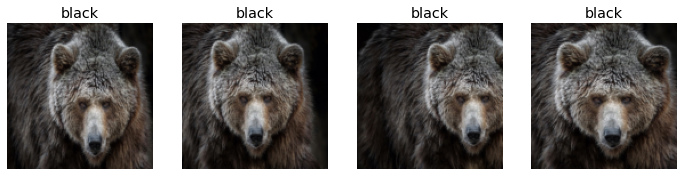

In [28]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

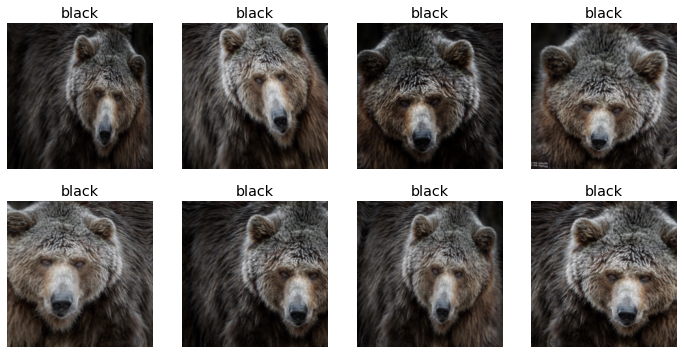

In [32]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)